<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Transfer_Learning_with_NSL_and_TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow recently released [Neural Structured Learning](https://www.tensorflow.org/neural_structured_learning). 

Neural Structured Learning (NSL) is a new learning paradigm to train neural networks by leveraging structured signals in addition to feature inputs. Structure can be explicit as represented by a graph or implicit as induced by adversarial perturbation. - [Source](https://www.tensorflow.org/neural_structured_learning). 

I was very intrigued when I first discovered about this since it not only enables adversarial learning but also accommodates other similar structures such as graphs. In this notebook, I aim to leverage NSL along with Transfer Learning and just see how it goes.

I used the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

![](https://i.ibb.co/WpxLdRy/Screen-Shot-2019-09-06-at-12-57-27-PM.png)

## Install TensorFlow 2.0 and `neural_structured_learning`

In [0]:
!pip install tensorflow-gpu==2.0.0-rc0 
!pip install --upgrade neural_structured_learning

## Imports

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
import neural_structured_learning as nsl
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2

## Setup

In [0]:
%matplotlib inline
np.random.seed(666)

## Data gathering

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

170500096/170498071 [==============================] - 4s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [0]:
# Since the labels are encoded as integers, we need to
# convert them to their original mappings for convenience
labels = ['airplane',
             'automobile',
             'bird',
             'cat',
             'deer',
             'dog',
             'frog',
             'horse',
             'ship',
             'truck']

## Scale the pixel values

In [0]:
X_train = X_train/255
X_test = X_test/255

## Data splitting

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)


In [7]:
X_train.shape, X_val.shape, X_test.shape

((42500, 32, 32, 3), (7500, 32, 32, 3), (10000, 32, 32, 3))

## Resizing the images and one-hot encoding of the labels

In [0]:
X_train = np.array([cv2.resize(x, (48, 48)) for x in X_train])
X_val = np.array([cv2.resize(x, (48, 48)) for x in X_val])                             
X_test = np.array([cv2.resize(x, (48, 48)) for x in X_test])                                  

In [0]:
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)


## Model construction

In [0]:
# Helper function to modify and compile (depends, though) a 
# VGG16 model
def get_model(nsl=False):
    base_model = keras.applications.VGG16(weights="imagenet", 
                 include_top=False, 
                 input_tensor=keras.layers.Input(shape=(48, 48, 3)))

    head_model = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(head_model)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.models.Model(inputs=base_model.input, outputs=x)

    for layer in base_model.layers:
        layer.trainable = False
    if nsl==False:
        model.compile(loss="binary_crossentropy", optimizer='adam',
            metrics=["accuracy"])
        return model
    else:
        return model

In [0]:
# Helper function to plot the metrics logged during training
def plot_training(H, N):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()


## Model training (without NSL) and evaluation

In [12]:
model = get_model()

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                   batch_size=128, epochs=2, verbose=1)
print("Took {0:.2f} seconds".format(time.time() - start))

Train on 42500 samples, validate on 7500 samples
Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
42500/42500 [==============================] - 35s 816us/sample - loss: 0.2252 - accuracy: 0.9156 - val_loss: 0.1894 - val_accuracy: 0.9265
Epoch 2/2
42500/42500 [==============================] - 28s 670us/sample - loss: 0.1870 - accuracy: 0.9275 - val_loss: 0.1753 - val_accuracy: 0.9326
Took 63.26 seconds


In [14]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.1782298050880432, 0.93016005]

In [22]:
probabilities = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(probabilities, axis=1),
                           target_names=labels))

              precision    recall  f1-score   support

    airplane       0.69      0.68      0.68      1000
  automobile       0.63      0.73      0.68      1000
        bird       0.55      0.53      0.54      1000
         cat       0.42      0.47      0.44      1000
        deer       0.60      0.52      0.56      1000
         dog       0.53      0.53      0.53      1000
        frog       0.62      0.71      0.66      1000
       horse       0.67      0.62      0.64      1000
        ship       0.70      0.70      0.70      1000
       truck       0.69      0.56      0.62      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



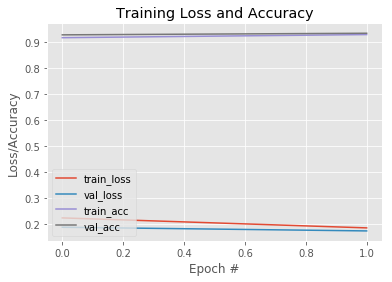

In [23]:
plot_training(history, 2)

## Model training with NSL and evaluation

Example taken from: https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist

In [0]:
model = get_model(nsl=True)
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)
adv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
# start = time.time()
# h = adv_model.fit({'feature': X_train, 'label': y_train},
#                   validation_data=(X_val, y_val),
#                   batch_size=128, epochs=2, verbose=1)
# print("Took {0:.2f} seconds".format(time.time() - start))

In [0]:
# start = time.time()
# h = adv_model.fit({'feature': X_train, 'label': y_train},
#                   validation_data={'feature': X_val, 'label': y_val},
#                   batch_size=128, epochs=2, verbose=1)
# print("Took {0:.2f} seconds".format(time.time() - start))

The `validation_data` argument does not seem to play nice. I have propagated this a [GitHub issue](https://github.com/tensorflow/tensorflow/issues/32279). Will update accordingly. 

In [25]:
start = time.time()
history = adv_model.fit({'feature': X_train, 'label': y_train},
                  batch_size=128, epochs=2, verbose=1)
print("Took {0:.2f} seconds".format(time.time() - start))

Train on 42500 samples
Epoch 1/2
42500/42500 [==============================] - 75s 2ms/sample - loss: 0.2727 - binary_crossentropy: 0.2236 - binary_accuracy: 0.9157 - adversarial_loss: 0.2461
Epoch 2/2
42500/42500 [==============================] - 71s 2ms/sample - loss: 0.2267 - binary_crossentropy: 0.1852 - binary_accuracy: 0.9280 - adversarial_loss: 0.2083
Took 151.16 seconds


In [26]:
# Third one is the accuracy
adv_model.evaluate({'feature': X_test, 'label': y_test})

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.21867283773422241, 0.17764342, 0.9303297, 0.20502284]

In [27]:
probabilities = adv_model.predict({'feature': X_test, 'label': y_test})
print(classification_report(np.argmax(y_test, axis=1), np.argmax(probabilities, axis=1),
                           target_names=labels))

              precision    recall  f1-score   support

    airplane       0.68      0.67      0.67      1000
  automobile       0.63      0.71      0.67      1000
        bird       0.59      0.47      0.52      1000
         cat       0.47      0.42      0.44      1000
        deer       0.57      0.58      0.57      1000
         dog       0.54      0.54      0.54      1000
        frog       0.62      0.71      0.66      1000
       horse       0.68      0.63      0.66      1000
        ship       0.70      0.73      0.72      1000
       truck       0.63      0.66      0.65      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000

